In [31]:
!pip install pyro-ppl

# **Import all modules**

In [32]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

# **Initialize Pyro Environment**

In [33]:
pyro.enable_validation(True)
pyro.set_rng_seed(0)

# **Basic probabilistic model**

In [ ]:
def model():
    p = pyro.sample("p", dist.Beta(2.0, 2.0))
    x = pyro.sample("x", dist.Bernoulli(p))
    return x

# **Conditioned (Posterior) Model**

In [35]:
def conditioned_model():
    p = pyro.sample("p", dist.Beta(2.0, 2.0))
    pyro.sample("x", dist.Bernoulli(p), obs=torch.tensor(1.0))
    return p

# **Bayesian Coin Flip Model (for inference and prediction)**

In [36]:
def flip_model(data=None):
    p = pyro.sample("p", dist.Beta(2.0, 2.0))
    if data is not None and len(data) > 0:
        with pyro.plate("data_plate", len(data)):
            pyro.sample("obs", dist.Bernoulli(p), obs=data)
    else:
        pyro.sample("obs", dist.Bernoulli(p))

# **Relation Reliability Model**

In [46]:
N_relations = 3

idx_fixed = torch.randint(0, N_relations, (100,))
mixed_data = torch.cat([torch.ones(70), torch.zeros(30)])
perm = torch.randperm(100)
idx_fixed = idx_fixed[perm]
mixed_data = mixed_data[perm]

def relation_model_all_ones():
    theta = pyro.sample("theta", dist.Beta(torch.ones(N_relations), torch.ones(N_relations)).to_event(1))
    with pyro.plate("data", len(idx_fixed)):
        pyro.sample("obs", dist.Bernoulli(theta[idx_fixed]), obs=torch.ones(len(idx_fixed)))
    return theta

def relation_model_mixed():
    theta = pyro.sample("theta", dist.Beta(torch.ones(N_relations), torch.ones(N_relations)).to_event(1))
    with pyro.plate("data", len(idx_fixed)):
        pyro.sample("obs", dist.Bernoulli(theta[idx_fixed]), obs=mixed_data)
    return theta


# **Run each model sequentially**

In [47]:
print("\n--- Basic Generative Model ---")
print("Random draw of p and x:", model())

print("\n--- Conditioned Model ---")
print("Posterior sample of p given x=1:", conditioned_model())

print("\n--- Coin Flip Model: Inference ---")
data = torch.tensor([1., 0., 1., 1., 0., 1., 1., 0., 1., 0.])
nuts_kernel = NUTS(flip_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data)
posterior_samples = mcmc.get_samples()
posterior_mean_p = posterior_samples["p"].mean().item()
print("Posterior mean of p:", posterior_mean_p)

predictive = Predictive(flip_model, posterior_samples)
new_data = predictive(None)
print("Predicted next flip samples:", new_data["obs"][:10])

print("\n--- Understanding to_event() ---")
dist_ind = dist.Normal(torch.zeros(3), torch.ones(3))
print("Before to_event:", dist_ind.batch_shape, dist_ind.event_shape)
dist_dep = dist_ind.to_event(1)
print("After to_event:", dist_dep.batch_shape, dist_dep.event_shape)

print("\n=== Relation Reliability Models: Comparison ===")

print("\n--- All Ones Conditioning ---")
nuts_kernel_all_ones = NUTS(relation_model_all_ones)
mcmc_all_ones = MCMC(nuts_kernel_all_ones, num_samples=500, warmup_steps=200)
mcmc_all_ones.run()
posterior_samples_all_ones = mcmc_all_ones.get_samples()
theta_samples_all_ones = posterior_samples_all_ones["theta"]
posterior_means_all_ones = theta_samples_all_ones.mean(0)
print("Posterior mean reliabilities:", posterior_means_all_ones.tolist())

print("\n--- Mixed Data Conditioning (70% ones) ---")
nuts_kernel_mixed = NUTS(relation_model_mixed)
mcmc_mixed = MCMC(nuts_kernel_mixed, num_samples=500, warmup_steps=200)
mcmc_mixed.run()
posterior_samples_mixed = mcmc_mixed.get_samples()
theta_samples_mixed = posterior_samples_mixed["theta"]
posterior_means_mixed = theta_samples_mixed.mean(0)
print("Posterior mean reliabilities:", posterior_means_mixed.tolist())



--- Basic Generative Model ---
Random draw of p and x: tensor(1.)

--- Conditioned Model ---
Posterior sample of p given x=1: tensor(0.6700)

--- Coin Flip Model: Inference ---


Sample: 100%|██████████| 1200/1200 [00:06, 173.79it/s, step size=1.25e+00, acc. prob=0.922]


Posterior mean of p: 0.5689992904663086
Predicted next flip samples: tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.])

--- Understanding to_event() ---
Before to_event: torch.Size([3]) torch.Size([])
After to_event: torch.Size([]) torch.Size([3])

=== Relation Reliability Models: Comparison ===

--- All Ones Conditioning ---


Sample: 100%|██████████| 700/700 [00:10, 68.44it/s, step size=5.35e-01, acc. prob=0.919]


Posterior mean reliabilities: [0.9718844890594482, 0.972061038017273, 0.9715566039085388]

--- Mixed Data Conditioning (70% ones) ---


Sample: 100%|██████████| 700/700 [00:07, 91.30it/s, step size=9.38e-01, acc. prob=0.918]

Posterior mean reliabilities: [0.6736102104187012, 0.698742151260376, 0.6853991746902466]


# **Visualization**

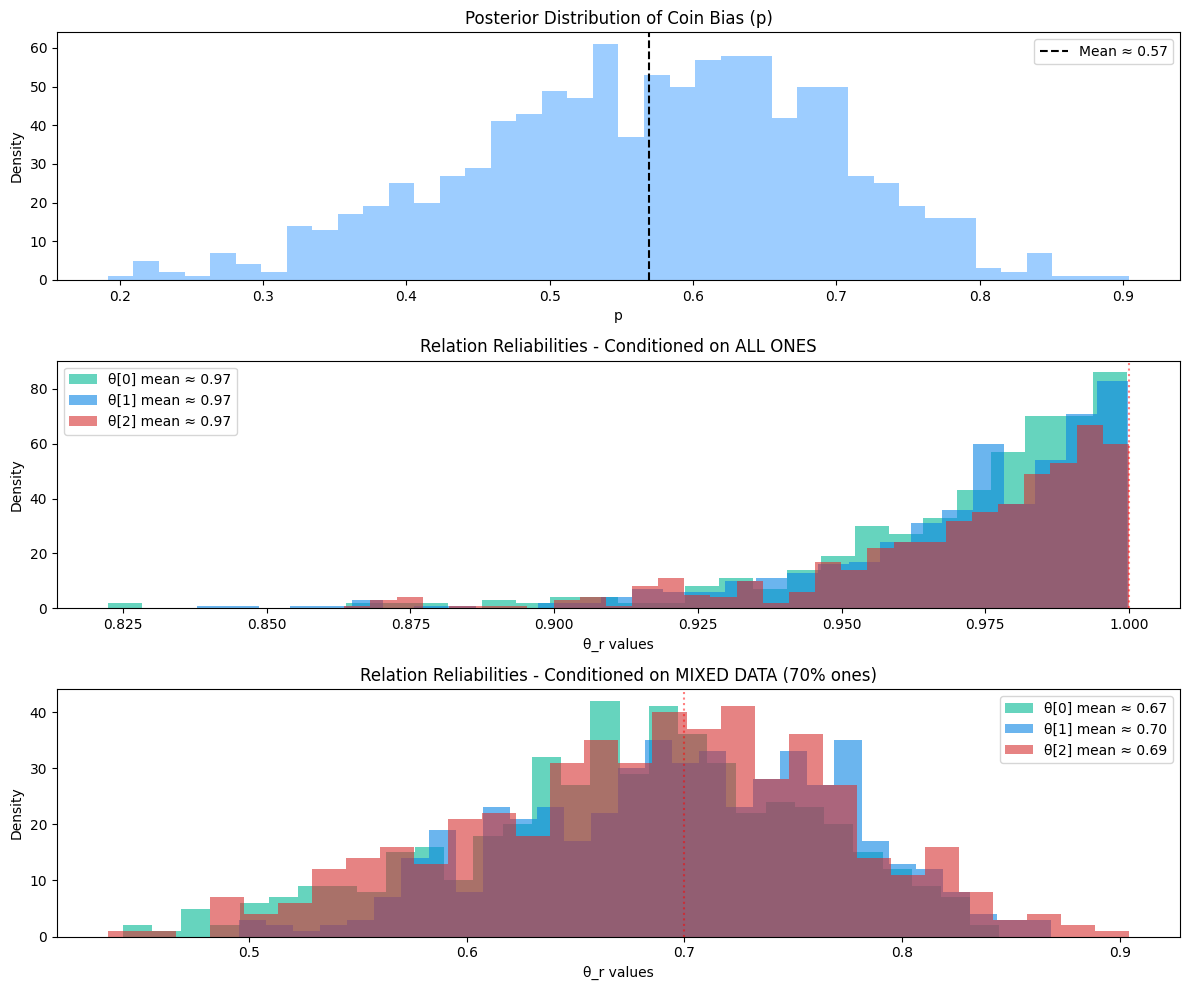

In [48]:
plt.figure(figsize=(12, 10))

# 1. Posterior of coin bias p
plt.subplot(3, 1, 1)
plt.hist(posterior_samples["p"].numpy(), bins=40, color="#74b9ff", alpha=0.7)
plt.axvline(posterior_mean_p, color="black", linestyle="--", label=f"Mean ≈ {posterior_mean_p:.2f}")
plt.title("Posterior Distribution of Coin Bias (p)")
plt.xlabel("p")
plt.ylabel("Density")
plt.legend()

# 2. Posterior of relation reliabilities - ALL ONES
plt.subplot(3, 1, 2)
colors = ["#00b894", "#0984e3", "#d63031"]
for i in range(N_relations):
    plt.hist(theta_samples_all_ones[:, i].numpy(), bins=30, alpha=0.6,
             label=f"θ[{i}] mean ≈ {posterior_means_all_ones[i]:.2f}", color=colors[i])
plt.title("Relation Reliabilities - Conditioned on ALL ONES")
plt.xlabel("θ_r values")
plt.ylabel("Density")
plt.legend()
plt.axvline(1.0, color='red', linestyle=':', alpha=0.5, label='Perfect reliability')

# 3. Posterior of relation reliabilities - MIXED DATA
plt.subplot(3, 1, 3)
for i in range(N_relations):
    plt.hist(theta_samples_mixed[:, i].numpy(), bins=30, alpha=0.6,
             label=f"θ[{i}] mean ≈ {posterior_means_mixed[i]:.2f}", color=colors[i])
plt.title("Relation Reliabilities - Conditioned on MIXED DATA (70% ones)")
plt.xlabel("θ_r values")
plt.ylabel("Density")
plt.legend()
plt.axvline(0.7, color='red', linestyle=':', alpha=0.5, label='True proportion')

plt.tight_layout()
plt.show()